<a href="https://colab.research.google.com/github/jencyfran/Apple-stock-price-prediction/blob/main/Apple_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
apple_stock_price = pd.read_csv('AAPL.csv')
apple_stock_price

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...,...
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900




## Checking the null values




In [4]:
apple_stock_price.isna().mean()

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

In [5]:
# convert 'Date' column to datetime format
apple_stock_price['Date'] = pd.to_datetime(apple_stock_price['Date'])


## Data Cleaning and visualization


In [6]:
apple_stock_price.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10468 non-null  datetime64[ns]
 1   Open       10468 non-null  float64       
 2   High       10468 non-null  float64       
 3   Low        10468 non-null  float64       
 4   Close      10468 non-null  float64       
 5   Adj Close  10468 non-null  float64       
 6   Volume     10468 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 572.6 KB


<Axes: >

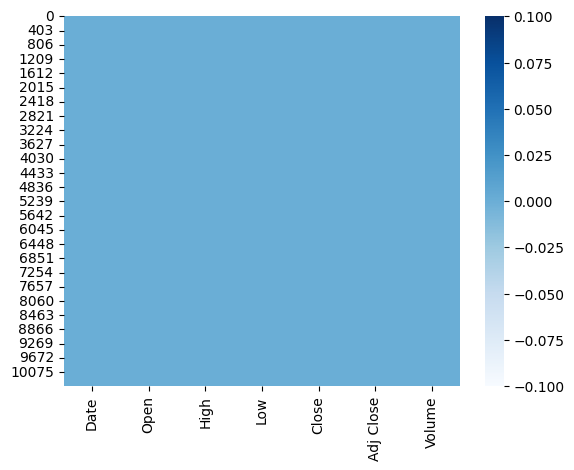

In [7]:
# This heatmap visulization is to find the missing values ("NaN") in the dataset
sns.heatmap(apple_stock_price.isnull(), cmap = 'Blues')

In [8]:
apple_stock_price.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,10468.0,1.475799e+01,3.191417e+01,0.049665,2.834820e-01,4.741070e-01,1.495330e+01,1.826300e+02
High,10468.0,1.492149e+01,3.228916e+01,0.049665,2.892860e-01,4.827675e-01,1.505714e+01,1.829400e+02
Low,10468.0,1.459448e+01,3.154396e+01,0.049107,2.767860e-01,4.659600e-01,1.469259e+01,1.791200e+02
Close,10468.0,1.476353e+01,3.192949e+01,0.049107,2.834820e-01,4.754460e-01,1.490196e+01,1.820100e+02
Adj Close,10468.0,1.413043e+01,3.163727e+01,0.038329,2.354620e-01,3.923730e-01,1.283527e+01,1.815117e+02
Volume,10468.0,3.308489e+08,3.388418e+08,0.000000,1.237768e+08,2.181592e+08,4.105794e+08,7.421641e+09


In [9]:
# This calculates the correlation between columns and stores the result in a new DataFrame. 

apple_stock_price_coorelation = apple_stock_price.corr()
apple_stock_price_coorelation


,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999943,0.999924,0.999850,0.999516,-0.196211
High,0.999943,1.000000,0.999908,0.999924,0.999618,-0.195635
Low,0.999924,0.999908,1.000000,0.999928,0.999575,-0.197150
Close,0.999850,0.999924,0.999928,1.000000,0.999671,-0.196411
Adj Close,0.999516,0.999618,0.999575,0.999671,1.000000,-0.199262
Volume,-0.196211,-0.195635,-0.197150,-0.196411,-0.199262,1.000000


<Axes: title={'center': 'Correlation Matrix'}>

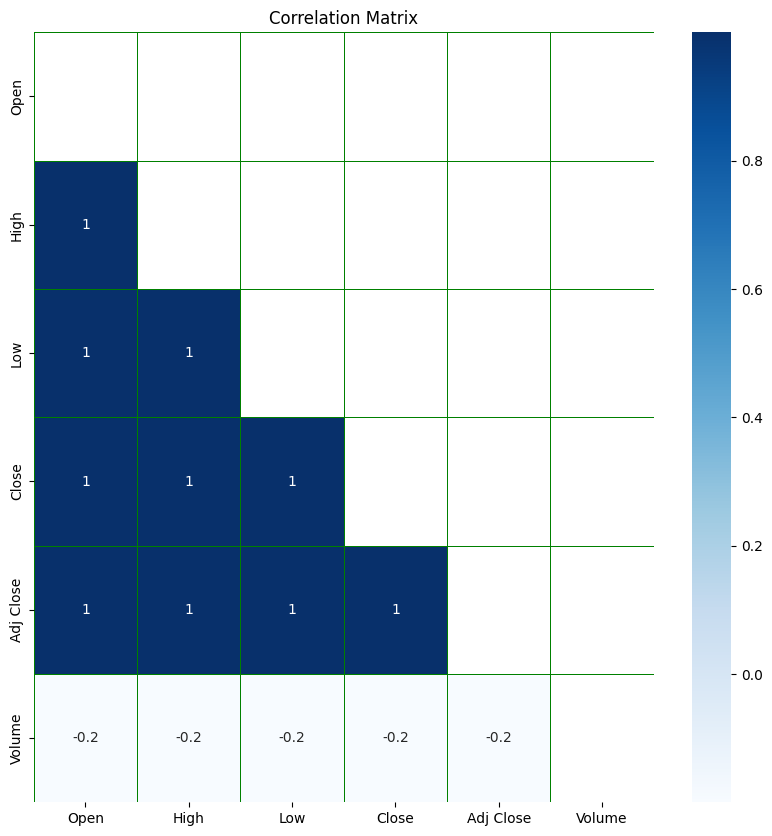

In [10]:
# Creating a heatmap visualization using the Seaborn library and Matplotlib.

plt.figure(figsize=(10,10))
mask = np.triu(apple_stock_price_coorelation)
plt.title("Correlation Matrix")
sns.heatmap(apple_stock_price_coorelation, mask = mask, cmap = 'Blues', annot = True, linewidth = 0.5, linecolor = 'Green')

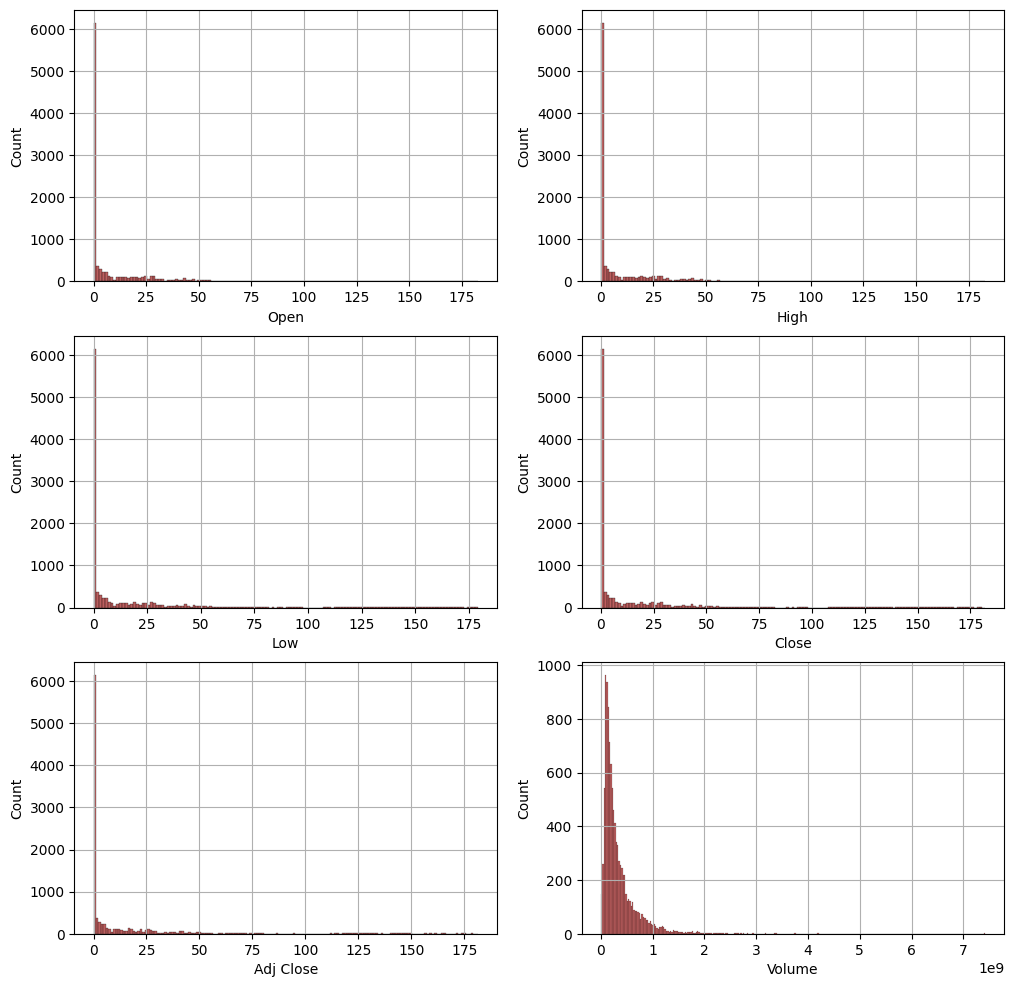

In [11]:
# visualizing the distribution of each column using Seaborn's distplot() function.

plt.figure(figsize=(12,12))

num_cols = len(apple_stock_price.columns) - 1
rows = 3
cols = 2

for i, col in enumerate(apple_stock_price.columns[1:]):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(apple_stock_price[col], color='brown')
    plt.grid()


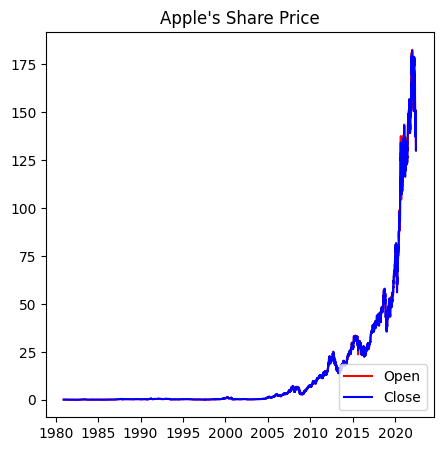

In [12]:
#plotting  the 'Open' and 'Close' prices of Apple's shares over time using the plt.plot()

plt.figure(figsize=(5,5))
plt.title("Apple's Share Price")
plt.plot(apple_stock_price['Date'], apple_stock_price['Open'], color = 'red', linewidth = 1.5, label = "Open")
plt.plot(apple_stock_price['Date'], apple_stock_price['Close'], color = 'blue', linewidth = 1.5, label = "Close")
plt.legend(loc ="lower right")

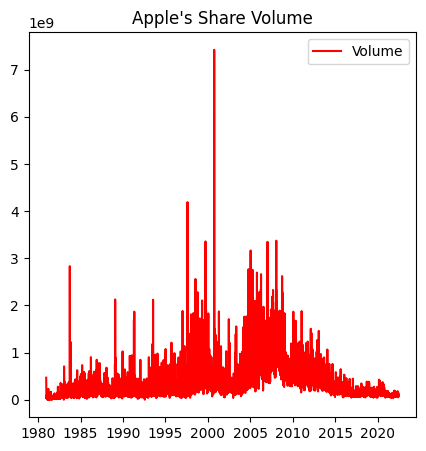

In [13]:
#plotting the volume of apple share trade over time

plt.figure(figsize=(5,5))
plt.title("Apple's Share Volume")
plt.plot(apple_stock_price['Date'], apple_stock_price['Volume'], color = 'red', linewidth = 1.5, label = "Volume")
plt.legend(loc ="upper right")

## Making a New Dataframe with Date & Close Price Only for the Prophet Model



In [14]:
new_df = apple_stock_price[['Date', 'Close']]
new_df

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10463,2022-06-13,131.880005
10464,2022-06-14,132.759995
10465,2022-06-15,135.429993
10466,2022-06-16,130.059998


In [15]:
new_df.rename(columns = {'Date' :'ds', 'Close' : 'y'}, inplace = True)

In [16]:
new_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

## Prophet Model

In [17]:
model = Prophet()
model.fit(new_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptl68w7i0/b0j6i4sl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptl68w7i0/m_55b3_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30290', 'data', 'file=/tmp/tmptl68w7i0/b0j6i4sl.json', 'init=/tmp/tmptl68w7i0/m_55b3_t.json', 'output', 'file=/tmp/tmptl68w7i0/prophet_modelslidp2ga/prophet_model-20230605180716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [19]:
# Making future prediction

df_future = model.make_future_dataframe(periods = 730)
forecast = model.predict(df_future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-12-12,0.109196,-11.511599,13.221371,0.109196,0.109196,0.400683,0.400683,0.400683,-0.089991,-0.089991,-0.089991,0.490674,0.490674,0.490674,0.0,0.0,0.0,0.509878
1,1980-12-15,0.109363,-11.986981,13.248475,0.109363,0.109363,0.548228,0.548228,0.548228,0.001537,0.001537,0.001537,0.546691,0.546691,0.546691,0.0,0.0,0.0,0.657591
2,1980-12-16,0.109419,-12.141604,13.186169,0.109419,0.109419,0.606618,0.606618,0.606618,0.040312,0.040312,0.040312,0.566305,0.566305,0.566305,0.0,0.0,0.0,0.716037
3,1980-12-17,0.109475,-11.408896,13.079523,0.109475,0.109475,0.624625,0.624625,0.624625,0.038433,0.038433,0.038433,0.586192,0.586192,0.586192,0.0,0.0,0.0,0.734100
4,1980-12-18,0.109531,-11.694241,13.326435,0.109531,0.109531,0.595241,0.595241,0.595241,-0.010932,-0.010932,-0.010932,0.606173,0.606173,0.606173,0.0,0.0,0.0,0.704772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11193,2024-06-12,161.044767,146.862344,174.152510,156.940286,165.061988,-0.681101,-0.681101,-0.681101,0.038433,0.038433,0.038433,-0.719534,-0.719534,-0.719534,0.0,0.0,0.0,160.363667
11194,2024-06-13,161.087892,145.606138,173.947384,156.978471,165.110618,-0.749813,-0.749813,-0.749813,-0.010932,-0.010932,-0.010932,-0.738881,-0.738881,-0.738881,0.0,0.0,0.0,160.338079
11195,2024-06-14,161.131017,147.541998,174.068443,157.017168,165.158056,-0.848318,-0.848318,-0.848318,-0.089991,-0.089991,-0.089991,-0.758327,-0.758327,-0.758327,0.0,0.0,0.0,160.282699
11196,2024-06-15,161.174142,147.186413,174.484512,157.055866,165.204301,-0.767094,-0.767094,-0.767094,0.010320,0.010320,0.010320,-0.777414,-0.777414,-0.777414,0.0,0.0,0.0,160.407048


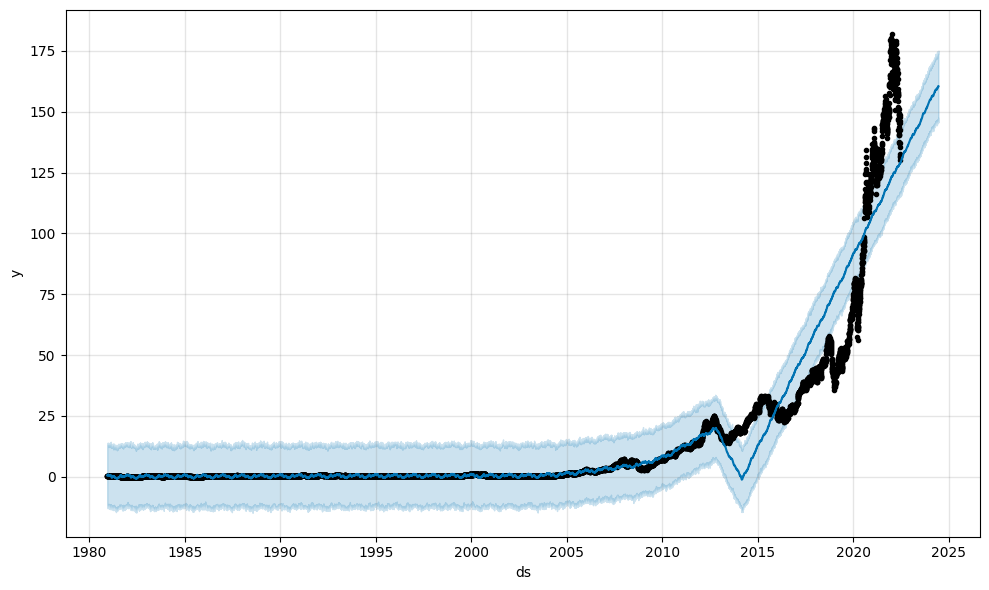

In [20]:
figure1 = model.plot(forecast)

In [21]:
plot_plotly(model, forecast)


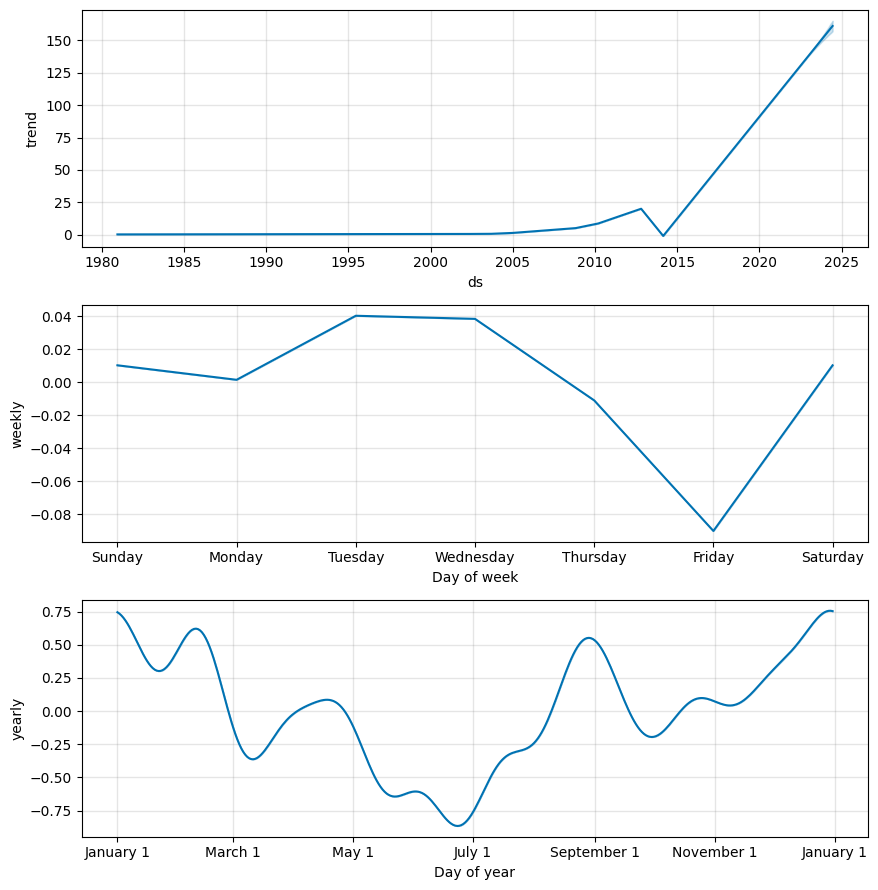

In [22]:
figure2 = model.plot_components(forecast)

In [23]:
plot_components_plotly(model, forecast)

## Performance Measurement of the Model 

* Cross Validation

In [ ]:
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon = '365 days')

In [25]:
df_cv


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1984-01-04,0.079443,0.065503,0.094001,0.124442,1984-01-03
1,1984-01-05,0.078672,0.064614,0.092450,0.126116,1984-01-03
2,1984-01-06,0.077599,0.062920,0.091025,0.123884,1984-01-03
3,1984-01-09,0.073090,0.058558,0.088698,0.117188,1984-01-03
4,1984-01-10,0.072224,0.058154,0.086529,0.123326,1984-01-03
...,...,...,...,...,...,...
19394,2022-06-13,101.209167,91.478562,110.736234,131.880005,2021-06-17
19395,2022-06-14,101.185108,90.850438,110.182960,132.759995,2021-06-17
19396,2022-06-15,101.169510,90.933238,110.457934,135.429993,2021-06-17
19397,2022-06-16,101.136171,91.133041,111.626820,130.059998,2021-06-17


In [26]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,103.436105,10.170354,3.340100,0.287533,0.217785,0.292810,0.232828
1,38 days,104.704664,10.232530,3.353034,0.288184,0.218927,0.294204,0.229928
2,39 days,107.728979,10.379257,3.397842,0.289888,0.222254,0.295980,0.227242
3,40 days,108.995972,10.440114,3.416846,0.290935,0.223574,0.296974,0.225316
4,41 days,109.647547,10.471272,3.428952,0.291518,0.223759,0.297711,0.222127


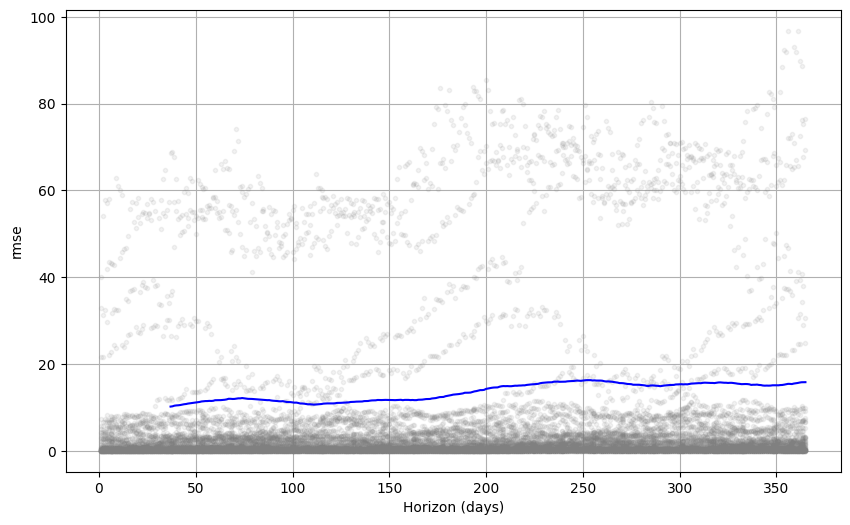

In [27]:
figure3 = plot_cross_validation_metric(df_cv, metric='rmse')

In [28]:
with open('Apple_Prophet_Model.json', 'w') as fout:
    fout.write(model_to_json(model)) 